In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 

In [5]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    cv2.namedWindow("opencv feed", cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty("opencv feed", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    while cap.isOpened():
        ret,frame= cap.read()
        image,results = mediapipe_detection(frame,holistic)
        print(results)
        draw_landmarks(image,results)
        cv2.imshow("opencv feed",frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

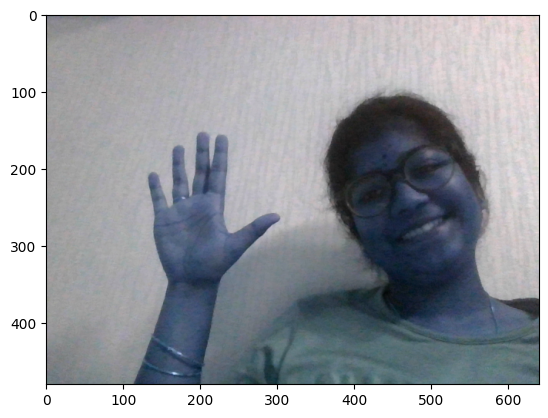

In [6]:
plt.imshow(frame)

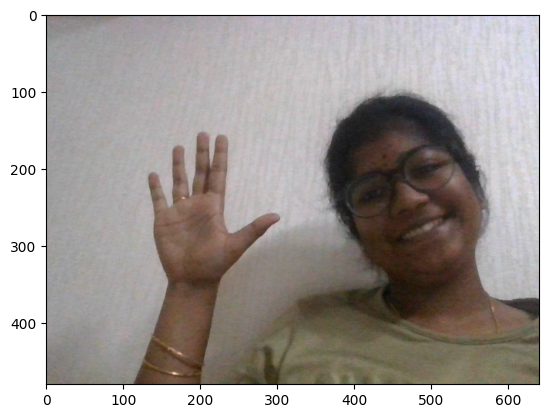

In [7]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

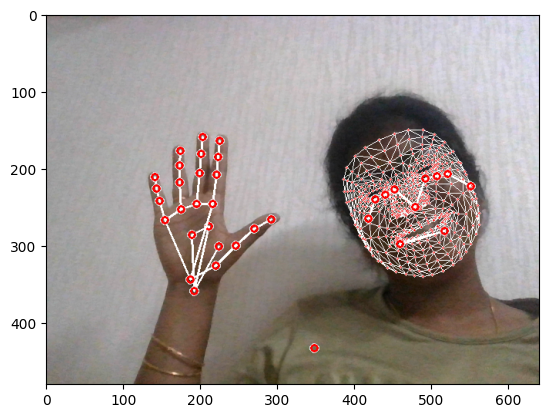

In [8]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [9]:
def extract_keypoints(results):
    aks=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    fks=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lks=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rks=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([aks,fks,lks,rks])

In [10]:
extract_keypoints(results).shape

(1662,)

In [11]:
result_test=extract_keypoints(results)
np.save('0',result_test)

In [12]:
np.load('0.npy')

array([ 0.74907029,  0.52122742, -0.98411477, ...,  0.2204487 ,
        0.43963966, -0.03875859])

In [14]:
source_dir = 'data' 
destination_dir = 'videos_plotted'  
for action_folder in os.listdir(source_dir):
    action_folder_path = os.path.join(source_dir, action_folder)
    if os.path.isdir(action_folder_path):
        destination_action_folder = os.path.join(destination_dir, action_folder)
        os.makedirs(destination_action_folder, exist_ok=True)
        for video_name in os.listdir(action_folder_path):
            video_path = os.path.join(action_folder_path, video_name)
            if video_name.endswith('.mp4'):  # Assuming videos have .mp4 extension
                cap = cv2.VideoCapture(video_path)
                fps = cap.get(cv2.CAP_PROP_FPS)
                width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                destination_video_path = os.path.join(destination_action_folder, video_name)
                out = cv2.VideoWriter(destination_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
                with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                    frame_count = 0
                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break

                        results = holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                        draw_landmarks(frame, results)

                        # Save the frame to the output video
                        out.write(frame)
                        frame_count += 1
                        print(f"Processed frame {frame_count} of {video_name}")



                cap.release()
                out.release()

print("Plotted videos have been saved.")


Processed frame 1 of boy_1.mp4
Processed frame 2 of boy_1.mp4
Processed frame 3 of boy_1.mp4
Processed frame 4 of boy_1.mp4
Processed frame 5 of boy_1.mp4
Processed frame 6 of boy_1.mp4
Processed frame 7 of boy_1.mp4
Processed frame 8 of boy_1.mp4
Processed frame 9 of boy_1.mp4
Processed frame 10 of boy_1.mp4
Processed frame 11 of boy_1.mp4
Processed frame 12 of boy_1.mp4
Processed frame 13 of boy_1.mp4
Processed frame 14 of boy_1.mp4
Processed frame 15 of boy_1.mp4
Processed frame 16 of boy_1.mp4
Processed frame 17 of boy_1.mp4
Processed frame 18 of boy_1.mp4
Processed frame 19 of boy_1.mp4
Processed frame 20 of boy_1.mp4
Processed frame 21 of boy_1.mp4
Processed frame 22 of boy_1.mp4
Processed frame 23 of boy_1.mp4
Processed frame 24 of boy_1.mp4
Processed frame 25 of boy_1.mp4
Processed frame 26 of boy_1.mp4
Processed frame 27 of boy_1.mp4
Processed frame 28 of boy_1.mp4
Processed frame 29 of boy_1.mp4
Processed frame 30 of boy_1.mp4
Processed frame 31 of boy_1.mp4
Processed frame 3